In [1]:
# import system libs 
import os
import time
import glob
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import load_img, img_to_array

#import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-03-21 05:05:26.202089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 05:05:26.202188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 05:05:26.385191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [3]:
picture_size = 48
folder_path = "/kaggle/input/face-expression-recognition-dataset/images"

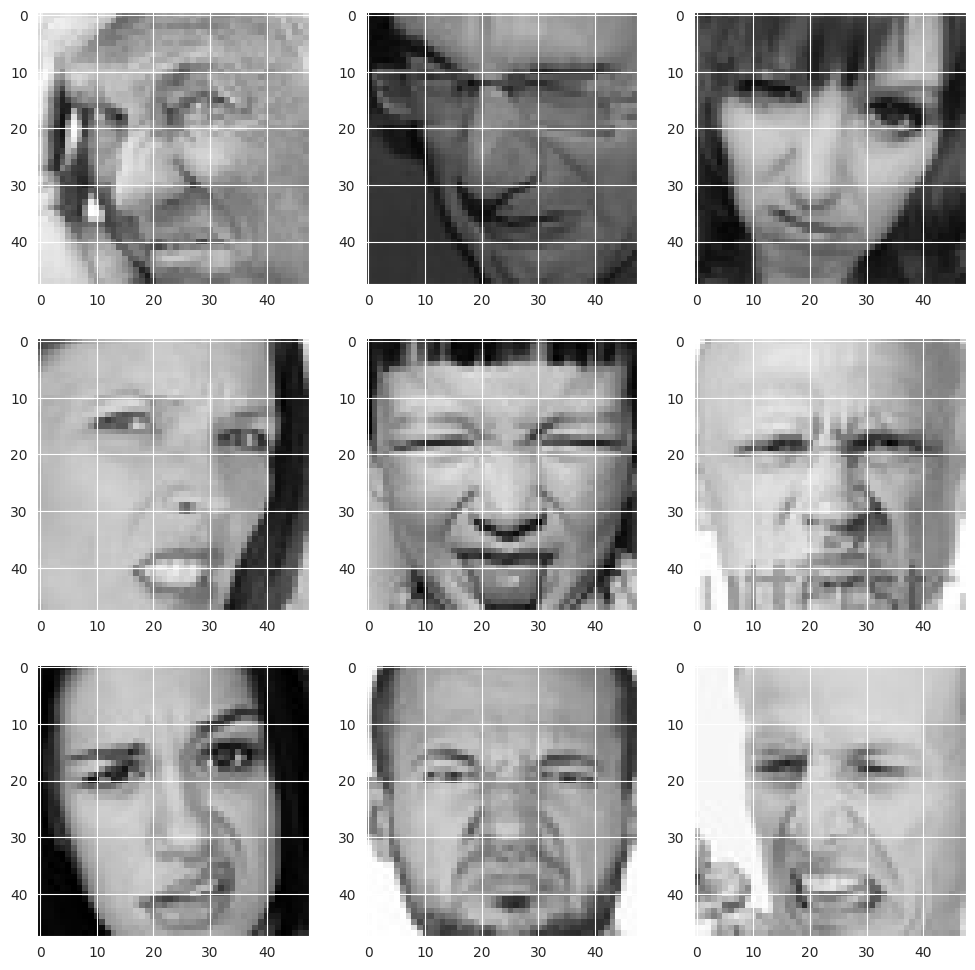

In [4]:
expression = 'disgust'

plt.figure(figsize=(12, 12))
# Get the list of images in the 'disgust' folder
img_list = os.listdir(os.path.join(folder_path, "train", expression))

# Check if there are 9 images in the 'disgust' folder
if len(img_list) >= 9:
    for i in range(1, 10, 1):
        plt.subplot(3, 3, i)
        img = load_img(os.path.join(folder_path, "train", expression, img_list[i]), target_size=(picture_size, picture_size))
        plt.imshow(img)
    plt.show()
else:
    print(f"Not enough images in the folder: {expression}")

In [5]:

folder_path = '/kaggle/input/face-expression-recognition-dataset/images/'

# Make sure the 'train' and 'validation' directories exist
print(f"Folder path: {folder_path}")
print(f"Train directory exists: {os.path.exists(os.path.join(folder_path, 'train'))}")
print(f"Validation directory exists: {os.path.exists(os.path.join(folder_path, 'validation'))}")

# Define picture size
picture_size = 48

# Define batch size
batch_size = 128

# Create image data generators
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

# Load the train and validation data
train_set = datagen_train.flow_from_directory(
    os.path.join(folder_path, 'train'),
    target_size=(picture_size, picture_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_set = datagen_val.flow_from_directory(
    os.path.join(folder_path, 'validation'),
    target_size=(picture_size, picture_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Folder path: /kaggle/input/face-expression-recognition-dataset/images/
Train directory exists: True
Validation directory exists: True
Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [6]:
no_of_classes = 7

model = Sequential()

# 1st CNN layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd CNN layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd CNN layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th CNN layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [7]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "./model.keras",  # Use '.keras' extension instead of '.h5'
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

reduce_learningrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 48

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [8]:
history = model.fit(
    x=train_set,  # Pass the generator directly to the 'x' argument
    steps_per_epoch=train_set.n//train_set.batch_size,
    epochs=epochs,
    validation_data=test_set,  # Pass the generator directly to the 'validation_data' argument
    validation_steps=test_set.n//test_set.batch_size,
    callbacks=callbacks_list
)

Epoch 1/48
  2/225 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.1348 - loss: 2.3463   

I0000 00:00:1710997615.070565     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710997615.096970     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/225 ━━━━━━━━━━━━━━━━━━━━ 2:03 691ms/step - accuracy: 0.2043 - loss: 2.1121

W0000 00:00:1710997646.107622     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.2571 - loss: 1.9350

W0000 00:00:1710997721.734509     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 157s 575ms/step - accuracy: 0.2576 - loss: 1.9336 - val_accuracy: 0.3449 - val_loss: 1.6832 - learning_rate: 0.0010
Epoch 2/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4297 - loss: 1.5171 - val_accuracy: 0.5000 - val_loss: 1.4771 - learning_rate: 0.0010
Epoch 3/48


W0000 00:00:1710997745.605515     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - accuracy: 0.4370 - loss: 1.4735 - val_accuracy: 0.4162 - val_loss: 1.6185 - learning_rate: 0.0010
Epoch 4/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 98us/step - accuracy: 0.4453 - loss: 1.3357 - val_accuracy: 0.3846 - val_loss: 1.9825 - learning_rate: 0.0010
Epoch 5/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - accuracy: 0.5040 - loss: 1.2990 - val_accuracy: 0.5310 - val_loss: 1.2531 - learning_rate: 0.0010
Epoch 6/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - accuracy: 0.5234 - loss: 1.2001 - val_accuracy: 0.6154 - val_loss: 1.3798 - learning_rate: 0.0010
Epoch 7/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 133ms/step - accuracy: 0.5442 - loss: 1.1894 - val_accuracy: 0.4733 - val_loss: 1.3274 - learning_rate: 0.0010
Epoch 8/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step - accuracy: 0.4922 - loss: 1.2381 - val_accuracy: 0.9231 - val_loss: 0.4426 - learning_rate: 0.0010
Epoch 9/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 131ms/step - accuracy: 0.5743 - loss: 1.11

In [9]:
model_json = model.to_json()
with open("model.json",'w') as json_file:
    json_file.write(model_json)
model.save("model.h5")

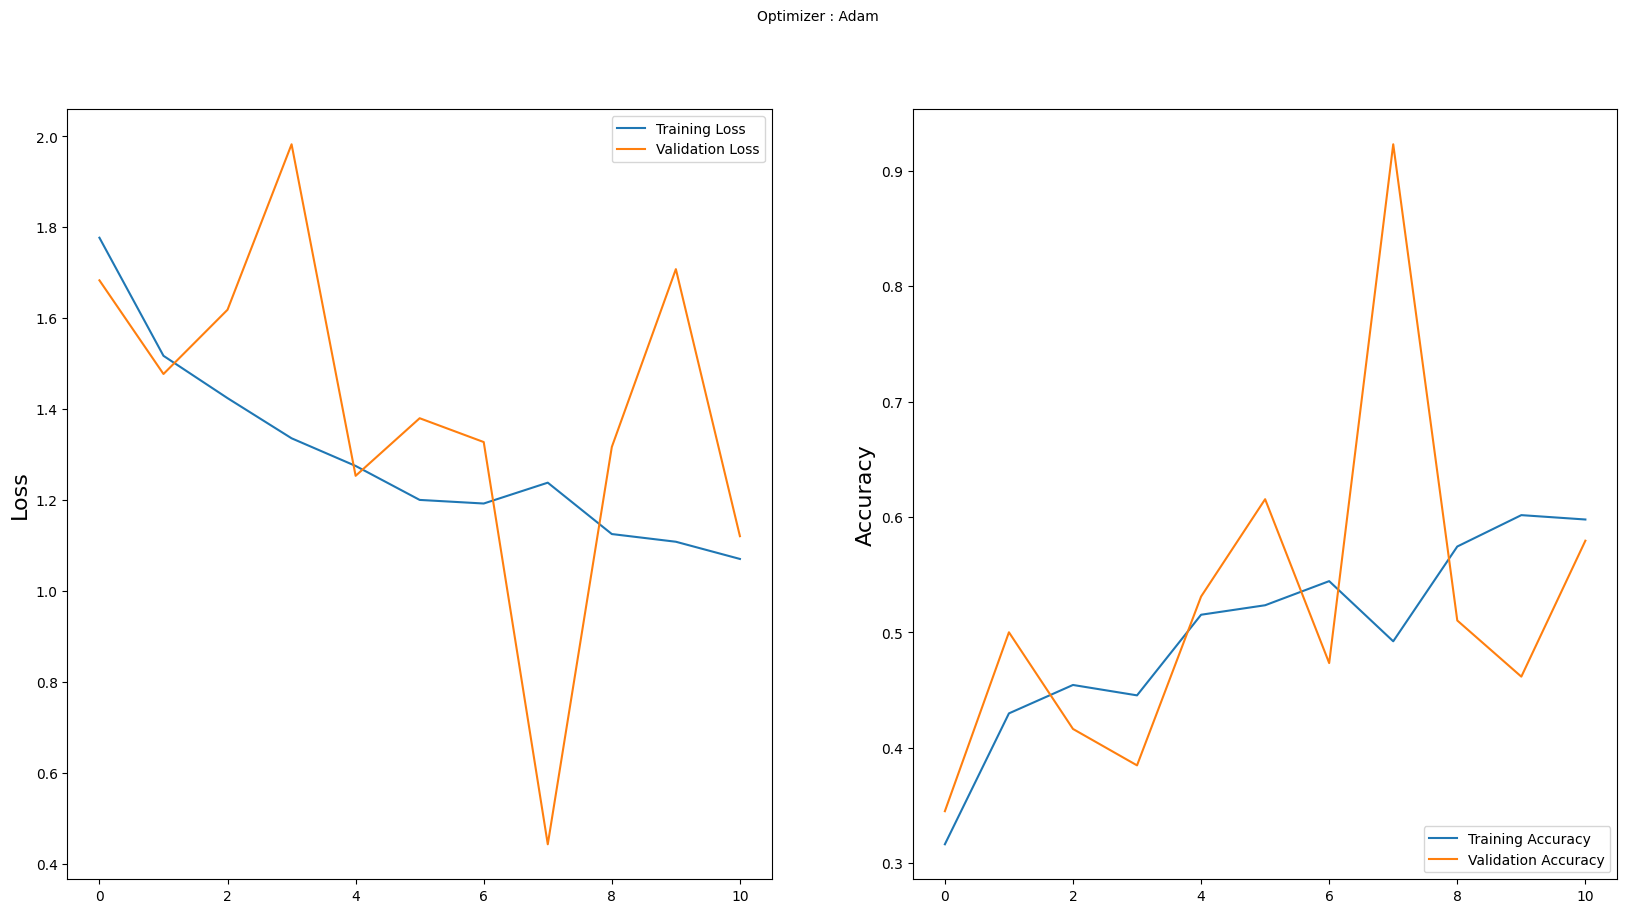

In [10]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [11]:
from keras.models import model_from_json

In [12]:
json_file = open("emotion_recog.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("emotion_recog.h5")

In [13]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [14]:
def ef(image):
    img = load_img(image,color_mode='grayscale' )
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

In [15]:
image = '/kaggle/input/face-expression-recognition-dataset/images/validation/sad/10031.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
model prediction is  sad
